## CMSC 35300 Final Project: Lasso Models
Shweta Kamath <br>
Nivedita Vatsa <br>
Carolyn Vilter

#### Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import data
df = pd.read_csv("data/all_data_standardized.csv")

In [3]:
# Separate out Xs
X = df.loc[:, ~df.columns.isin(["child_id", "mother_id", "treat_alike_scale", "treat_alike_binary"])]
X = X.to_numpy()

# Separate out two prospective ys
y_scale = df.loc[:, df.columns == "treat_alike_scale"]
y_scale = y_scale.to_numpy()

y_binary = df.loc[:, df.columns == "treat_alike_binary"]
y_binary = y_binary.to_numpy()

### Lasso Regression
Predict repeatedly using cross validation; plot test error.

In [4]:
class Regression:
    def __init__(self, learning_rate, iteration, regularization):
        """
        :param learning_rate: A samll value needed for gradient decent, default value id 0.1.
        :param iteration: Number of training iteration, default value is 10,000.
        """
        self.m = None
        self.n = None
        self.w = None
        self.b = None
        self.regularization = regularization # will be the l1/l2 regularization class according to the regression model.
        self.lr = learning_rate
        self.it = iteration

    def cost_function(self, y, y_pred):
        """
        :param y: Original target value.
        :param y_pred: predicted target value.
        """
        return (1 / (2*self.m)) * np.sum(np.square(y_pred - y)) + self.regularization(self.w)
    
    def hypothesis(self, weights, bias, X):
        """
        :param weights: parameter value weight.
        :param X: Training samples.
        """
        return np.dot(X, weights) #+ bias

    def train(self, X, y):
        """
        :param X: training data feature values ---> N Dimentional vector.
        :param y: training data target value -----> 1 Dimentional array.
        """
        # Insert constant ones for bias weights.
        X = np.insert(X, 0, 1, axis=1)

        # Target value should be in the shape of (n, 1) not (n, ).
        # So, this will check that and change the shape to (n, 1), if not.
        try:
            y.shape[1]
        except IndexError as e:
            # we need to change it to the 1 D array, not a list.
            print("ERROR: Target array should be a one dimentional array not a list"
                  "----> here the target value not in the shape of (n,1). \nShape ({shape_y_0},1) and {shape_y} not match"
                  .format(shape_y_0 = y.shape[0] , shape_y = y.shape))
            return 
        
        # m is the number of training samples.
        self.m = X.shape[0]
        # n is the number of features.
        self.n = X.shape[1]

        # Set the initial weight.
        self.w = np.zeros((self.n , 1))

        # bias.
        self.b = 0

        for it in range(1, self.it+1):
            # 1. Find the predicted value through the hypothesis.
            # 2. Find the Cost function value.
            # 3. Find the derivation of weights.
            # 4. Apply Gradient Decent.
            y_pred = self.hypothesis(self.w, self.b, X)
            #print("iteration",it)
            #print("y predict value",y_pred)
            cost = self.cost_function(y, y_pred)
            #print("Cost function",cost)
            # fin the derivative.
            dw = (1/self.m) * np.dot(X.T, (y_pred - y)) + self.regularization.derivation(self.w)
            #print("weights derivation",dw)
            #db = -(2 / self.m) * np.sum((y_pred - y))

            # change the weight parameter.
            self.w = self.w - self.lr * dw
            #print("updated weights",self.w)
            #self.b = self.b - self.lr * db

            if it % 10000 == 0:
                print("The Cost function for the iteration {}----->{}".format(it, cost))
                
    def predict(self, test_X):
        """
        :param test_X: feature values to predict.
        """
        # Insert constant ones for bias weights.
        test_X = np.insert(test_X, 0, 1, axis=1)

        y_pred = self.hypothesis(self.w, self.b, test_X)
        return y_pred

In [5]:
class l1_regularization:
    '''Regularization used for Lasso Regression'''
    def __init__(self, lamda):
        self.lamda = lamda

    def __call__(self, weights):
        '''This will be retuned when we call this class.'''
        return self.lamda * np.sum(np.abs(weights))
    
    def derivation(self, weights):
        "Derivation of the regulariozation function."
        return self.lamda * np.sign(weights)

In [6]:
class l2_regularization:
    '''Regularization used for Ridge Regression'''
    def __init__(self, lamda):
        self.lamda = lamda

    def __call__(self, weights):
        "This will be retuned when we call this class."
        return self.lamda * np.sum(np.square(weights))
    
    def derivation(self, weights):
        "Derivation of the regulariozation function."
        return self.lamda * 2 * (weights)

In [7]:
class LassoRegression(Regression):
    '''
    '''
    def __init__(self, lamda, learning_rate, iteration):
        '''
        Define the hyperparameters we are going to use in this model.
        :param lamda: Regularization factor.
        :param learning_rate: A samll value needed for gradient decent, default value id 0.1.
        :param iteration: Number of training iteration, default value is 10,000.
        '''
        self.regularization = l1_regularization(lamda)
        super(LassoRegression, self).__init__(learning_rate, iteration, self.regularization)

    def train(self, X, y):
        '''
        :param X: training data feature values ---> N Dimentional vector.
        :param y: training data target value -----> 1 Dimentional array.
        '''
        return super(LassoRegression, self).train(X, y)
    
    def predict(self, test_X):
        '''
        parma test_X: Value need to be predicted.
        '''
        return super(LassoRegression, self).predict(test_X)

In [8]:
class RidgeRegression(Regression):
    '''
    Ridge Regression is one of the variance of the Linear Regression. This model doing the parameter learning 
    and regularization at the same time. This model uses the l2-regularization. 
    This is very similar to the Lasso regression.
    * Regularization will be one of the soluions to the Overfitting.
    * Overfitting happens when the model has "High Variance and low bias". So, regularization adds a little bias to the model.
    * This model will try to keep the balance between learning the parameters and the complexity of the model( tries to keep the parameter having small value and small degree of palinamial).
    * The Regularization parameter(lamda) controls how severe  the regularization is. 
    * large lamda adds more bias , hence the Variance will go very small --> this may cause underfitting(Low bias and High Varinace).
    * Lamda can be found by tial and error methos. 
    '''
    def __init__(self, lamda, learning_rate, iteration):
        """
        Define the hyperparameters we are going to use in this model.
        :param lamda: Regularization factor.
        :param learning_rate: A samll value needed for gradient decent, default value id 0.1.
        :param iteration: Number of training iteration, default value is 10,000.
        """
        self.regularization = l2_regularization(lamda)
        super(RidgeRegression, self).__init__(learning_rate, iteration, self.regularization)

    def train(self, X, y):
        """
        :param X: training data feature values ---> N Dimentional vector.
        :param y: training data target value -----> 1 Dimentional array.
        """
        return super(RidgeRegression, self).train(X, y)
    def predict(self, test_X):
        """
        parma test_X: Value need to be predicted.
        """
        return super(RidgeRegression, self).predict(test_X)

In [9]:
def predict_scale_labels(y_scale_pred):
    '''
    Assign label 1 through 4
    
    arg:
    - y_scale_pred: vector of predicted y values
    
    Returns: vector of predicted y labels (1 through 4)
    '''
    # generate nx4 matrix where each column is 1,2,3,4
    m, _ = y_scale_pred.shape
    mat = np.tile(np.arange(4)+1, (m,1))
    
    # find lowest absolute distance
    return np.argmin(abs(mat - y_scale_pred), axis=1).reshape(m, 1)

### Estimate Lasso Model

In [14]:
param = {"lamda" : 0,
         "learning_rate" : 10**(-10),
         "iteration" : 800000}

lasso = LassoRegression(**param)
lasso.train(X, y_scale)

# predict
y_scale_pred = lasso.predict(X)

The Cost function for the iteration 1000----->0.41679908332692683
The Cost function for the iteration 2000----->0.28518990027337116
The Cost function for the iteration 3000----->0.24278528202110722
The Cost function for the iteration 4000----->0.22808387943344677
The Cost function for the iteration 5000----->0.22214167586702094
The Cost function for the iteration 6000----->0.21910046089054594
The Cost function for the iteration 7000----->0.2171291057448461
The Cost function for the iteration 8000----->0.21563866925776792
The Cost function for the iteration 9000----->0.21442582462138762
The Cost function for the iteration 10000----->0.21340903572559092
The Cost function for the iteration 11000----->0.21254699258617635
The Cost function for the iteration 12000----->0.21181313305741853
The Cost function for the iteration 13000----->0.21118746236086477
The Cost function for the iteration 14000----->0.21065374029978462
The Cost function for the iteration 15000----->0.21019836200157604
The C

In [11]:
X_names = df.columns[(~df.columns.isin(["child_id", "mother_id", "treat_alike_scale", "treat_alike_binary"]))]

filt = (np.round(lasso.w[1:], 4)>0.0).flatten()
b_names = X_names[filt]
b_vals  = lasso.w[1:][filt]

print("---most important features---")
for n, v in zip(b_names, b_vals):
    print(n, ":", '%.08f' % v)

---most important features---
year_at_y : 0.00036801
yob_child : 0.00036552


In [12]:
print("---error rate---")
y_scale_pred_label = predict_scale_labels(y_scale_pred)
100*np.sum(y_scale != y_scale_pred_label)/len(y_scale)

print("---mean square error ---")
mse = (np.square(y_scale - y_scale_pred)).mean(axis=None)
mse

---error rate---
---mean square error ---


0.4151945204879751

[Text(0.5, 1.0, 'Prediction by Label')]

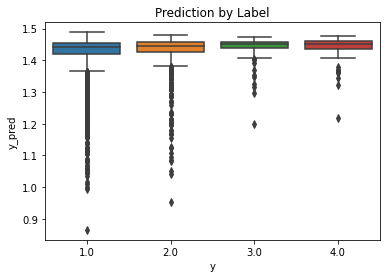

In [13]:
# # visualize results
results = pd.DataFrame(data=np.hstack((y_scale, y_scale_pred)),
             columns=["y", "y_pred"])

sns.boxplot(data=results, x='y', y='y_pred').set(title='Prediction by Label')